In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###**Detectron2'yi Colab'a Yükleme**


In [ ]:
!pip install pyyaml==5.1
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# After this step it will ask you to restart the runtime, please do it.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html


In [ ]:
import torch
assert torch.__version__.startswith("1.8") 
import torchvision
import cv2

In [ ]:
import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

### Burada, veri seti kendi özel formatındadır, bu nedenle onu ayrıştırmak ve onu dedektör2'nin standart formatına hazırlamak için bir fonksiyon yazıyoruz. Kullanıcı, özel biçimde bir veri kümesi kullanırken böyle bir işlevi kullanmalıdır.

###**Verileri Detectron2 Yapılandırmasına Uygun Şekilde Kaydetme**

In [ ]:
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = 700
        record["width"] = 700
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x coord
            py = [a[1] for a in anno['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": classes.index(anno['label']),
                "segmentation": [poly],
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [ ]:
classes = ['sen']

data_path = '/content/drive/MyDrive/data/'

for d in ["train", "test"]:
    DatasetCatalog.register(
        "my_" + d, 
        lambda d=d: get_data_dicts(data_path+d, classes)
    )
    MetadataCatalog.get("my_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("my_train")

###**Detectron2 Segmentasyon Modelinin Eğitimi**


In [ ]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer
from matplotlib.patches import Rectangle

###**Yapılandırma Dosyasını Oluşturma**

In [ ]:
cfg = get_cfg() # Yapılandırma Dosyasını Oluşturuyoruz
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml")) # Yapılandırma Dosyasını Çeker ve Yapılandırma Dosyasına Ekler
cfg.DATASETS.TRAIN = ("my_train",) # Train Verilerimiz Yapılandırma Dosyasına Kaydeder
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2 # Çalışan Sayısı
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml") # Ağırlıkları Çeker ve Yapılandırma Dosyasına Ekler
cfg.SOLVER.IMS_PER_BATCH = 2 # Batch Size
cfg.SOLVER.BASE_LR = 0.001 # Learning Rate (Öğrenme Oranı)
cfg.SOLVER.GAMMA = 0.05 # Learning Rate Azaltma Çarpımı
cfg.SOLVER.STEPS = [500] # Learning Rate Azaltma Adım Sayısı
cfg.TEST.EVAL_PERIOD = 200 # Eğitim Sırasında Modeli Değerlendirmek İçin Adım Sayısı

cfg.SOLVER.MAX_ITER = 1000 # İterasyon Sayısı
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # Sınıf Sayısı

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True) # Model Sonucu İçin Klasör Oluşturur
trainer = DefaultTrainer(cfg) # Modeli Train Moduna Geçirir Yapılandırma Dosyası ile Birlikte
trainer.resume_or_load(resume=False) # Model Eğitimine 0'dan Başlamak İçin False Yapıyoruz 

[12/26 13:08:05 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

model_final_4ce675.pkl: 144MB [00:13, 10.5MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


In [ ]:
trainer.train() # Model Eğitimine Başlar

[12/26 13:08:53 d2.engine.train_loop]: Starting training from iteration 0
[12/26 13:09:24 d2.utils.events]:  eta: 0:24:32  iter: 19  total_loss: 1.337  loss_cls: 0.4902  loss_box_reg: 0.1386  loss_mask: 0.6818  loss_rpn_cls: 0.0343  loss_rpn_loc: 0.002027  time: 1.5163  data_time: 0.0696  lr: 1.931e-06  max_mem: 4658M
[12/26 13:09:57 d2.utils.events]:  eta: 0:25:09  iter: 39  total_loss: 1.285  loss_cls: 0.4392  loss_box_reg: 0.1453  loss_mask: 0.6709  loss_rpn_cls: 0.03182  loss_rpn_loc: 0.002833  time: 1.5718  data_time: 0.0084  lr: 2.911e-06  max_mem: 4658M
[12/26 13:10:30 d2.utils.events]:  eta: 0:25:18  iter: 59  total_loss: 1.202  loss_cls: 0.3638  loss_box_reg: 0.1607  loss_mask: 0.6528  loss_rpn_cls: 0.03327  loss_rpn_loc: 0.003121  time: 1.6102  data_time: 0.0074  lr: 3.891e-06  max_mem: 4658M
[12/26 13:11:03 d2.utils.events]:  eta: 0:24:46  iter: 79  total_loss: 1.089  loss_cls: 0.2802  loss_box_reg: 0.1506  loss_mask: 0.6257  loss_rpn_cls: 0.03593  loss_rpn_loc: 0.00269  tim

###**Eğitilmiş Model testi**

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") # Ağırlık Dosyamızı Yapılandırma Dosyamıza Kaydeder
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4 # Test için Eşik Değerimiz
cfg.DATASETS.TEST = ("my_test", ) # Tets Verilerimiz Yapılandırma Dosyasına Kaydeder
predictor = DefaultPredictor(cfg) #Modeli Test Moduna Geçirir Yapılandırma Dosyası ile Birlikte
test_metadata = MetadataCatalog.get("my_test")
test_dataset_dicts = get_data_dicts(data_path+'test', classes)

###**Resim Testi**

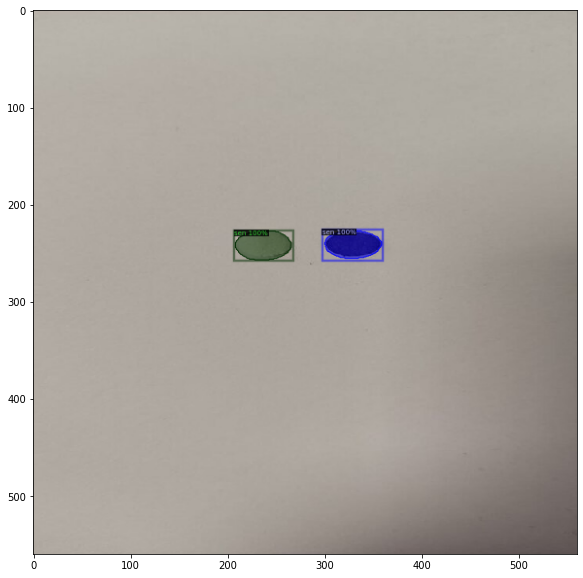

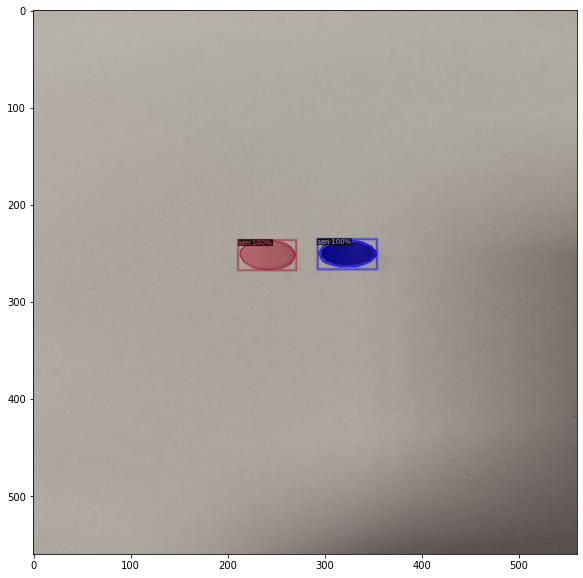

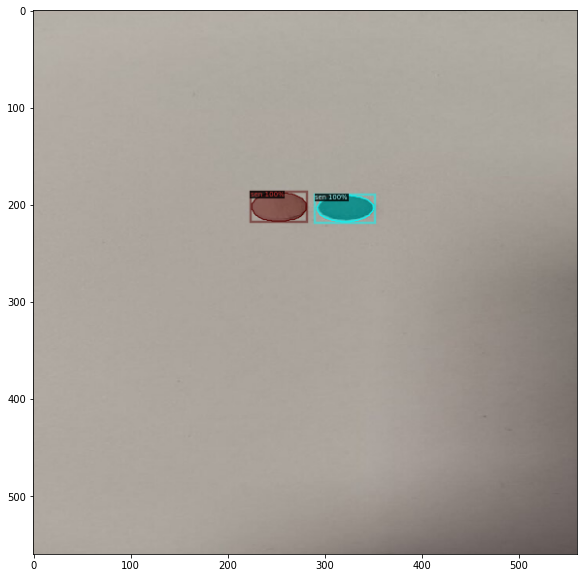

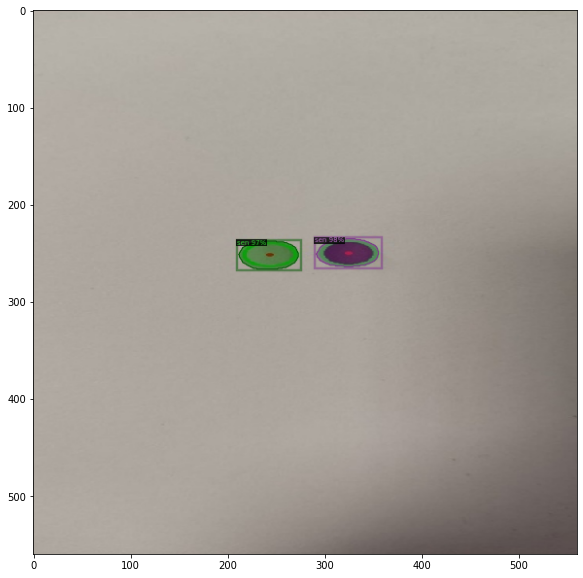

In [ ]:
for d in random.sample(test_dataset_dicts, 4):    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   #instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (20, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

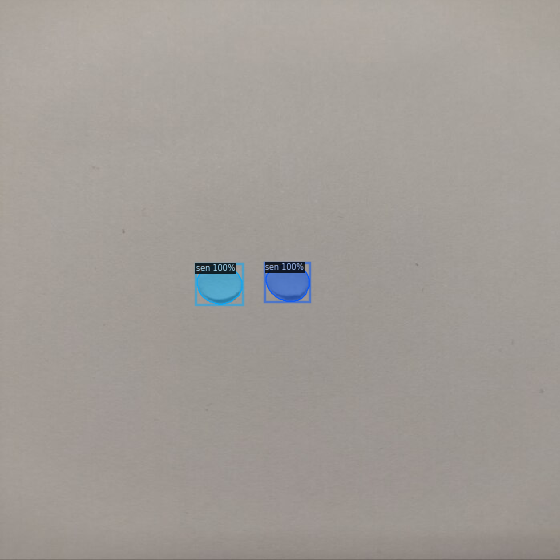

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob
from google.colab.patches import cv2_imshow
for imageName in glob.glob('/content/drive/MyDrive/data/asd/W-0.0125.jpeg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])